## MNIST Data

Binary classification based on MNIST data - classifying whether a given image contains the digit '5' or not.
A smaller ('lightweight') version of MNIST is used - containing 8x8 images that are included in the scikit-learn library.

In the following, we use the following notation (see also the notations sheet):

m: Number of samples <br>
n: Number of features

### Data Preparation

#### Load Data 

Image Data Shape (1797, 64)
Label Data Shape (1797,)
[[ 0.  0.  1.  8. 15. 10.  0.  0.]
 [ 0.  3. 13. 15. 14. 14.  0.  0.]
 [ 0.  5. 10.  0. 10. 12.  0.  0.]
 [ 0.  0.  3.  5. 15. 10.  2.  0.]
 [ 0.  0. 16. 16. 16. 16. 12.  0.]
 [ 0.  1.  8. 12. 14.  8.  3.  0.]
 [ 0.  0.  0. 10. 13.  0.  0.  0.]
 [ 0.  0.  0. 11.  9.  0.  0.  0.]]
7


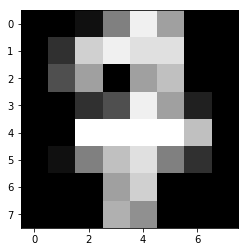

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_digits
digits = load_digits()
x = digits.data
y = digits.target
print("Image Data Shape" , x.shape)
print("Label Data Shape", y.shape)

image = x[17,:]
plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
print(np.reshape(image, (8,8)))
print(y[17])

#### Split Data and bring it in the correct shape

Split the data into training set and test set.
We use the scikit-learn function 'train_test_split' and use a (80%/20%) splitting.

Furthermore, we bring the input data (x) into the shape (n,m) where n is the number of input features and m the number of samples.  

In [2]:
from sklearn.model_selection import train_test_split

# split
x_train0, x_test0, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

# reshape: 
# for x a simple transpose is sufficient 
# (m,n) -> (n,m) where m is the number of samples and n the number of input features (pixels)
# for y reshape the simple array to become a (1,m) array
x_train1 = x_train0.T
x_test1 = x_test0.T
m_train = x_train0.shape[0]
m_test = x_test0.shape[0]
y_train=y_train.reshape(1,m_train)
y_test=y_test.reshape(1,m_test)

print("Shape training set: ", x_train1.shape, y_train.shape)
print("Shape test set:     ", x_test1.shape, y_test.shape)

Shape training set:  (64, 1437) (1, 1437)
Shape test set:      (64, 360) (1, 360)


#### Data Normalisation

Rescale the data - apply min/max rescaling (- we get back to centering later).

Test that the result is expected.

In [3]:
import numpy as np
xmax = np.max(x_train1)
xmin = np.min(x_train1)
print(xmin, xmax)
x_train = x_train1 / xmax
x_test = x_test1 / xmax

0.0 16.0


### Perceptron-Model

In [4]:
def sigmoid(z):
    """
    Compute the sigmoid of z
    Arguments:
    z -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(z)
    """
    ### START YOUR CODE ###
    return 1 / (1 + math.exp(-z))
    ### END YOUR CODE ###

In [5]:
def predict(w, b, X, round=False):
    '''
    Compute the prediction for each of the m samples by using the parameters (w, b).
    Return the numeric value if `round=False` - return a rounded value (0 or 1) if `round=True`. 
    
    Arguments:
    w -- weights, a numpy array with shape (1, n)
    b -- bias, a scalar
    X -- data of size (n,m)
    round -- flag to indicate whether to round or not.
    
    Returns:
    predictions -- a numpy array (vector) containing all predictions
    ''' 
    ### START YOUR CODE ###
    y = np.dot(w, X) + b
    if round:
        y[y>=0] = 1.
        y[y<0] = 0.
        return y
    return y
    ### END YOUR CODE ###

### Cost Function

* Cross-Entropy Cost Function
* Mean Square Error Function

In [6]:
def reshapey(yhat,y):
    """
    Checks whether the inputs come as a list in which case it reshapes it to (1,m).
    Implementation is sloppy...
    """
    if type(yhat).__module__ == np.__name__:
        m = yhat.size
        yhat = yhat.reshape(1,m)
        y = y.reshape(1,m)
    else:
        m = 1
    return yhat, y, m

In [7]:
def cost_CE(yhat, y):
    """
    Computes the cross entropy cost function for given predicted values and labels.
    
    Parameters:
    yhat -- A scalar or numpy array with shape (1,m).
    y    -- A scalar or numpy array with shape (1,m).
    
    Returns:
    Cross Entropy Cost
    """    
    yhat, y, m = reshapey(yhat, y)
    
    ### START YOUR CODE ###
    #from https://gist.github.com/Atlas7/22372a4f6b0846cfc3797766d7b529e8
    cost = -(1.0/m) * np.sum(y*np.log(yhat) + (1-y)*np.log(1-yhat)) #TODO this function is wrong. the np.log (1-yhat) returns less than zero
    return cost
    ### END YOUR CODE ###

In [8]:
def cost_MSE(yhat, y):
    """
    Computes the mean square error cost function for given predicted values and labels.
    
    Parameters:
    yhat -- A scalar or numpy array with shape (1,m).
    y    -- A scalar or numpy array with shape (1,m).
    
    Returns:
    MSE Cost
    """    
    yhat, y, m = reshapey(yhat, y)

    ### START YOUR CODE ###
    cost = 1 / (2*m) * np.sum((yhat - y)**2)
    cost2 = np.square(np.subtract(yhat, y)).mean()
    if cost != cost2:
        raise Exception('not the same costs', cost, ' ', cost2)
    return cost
    ### END YOUR CODE ###

### Update Rules for the Parameters

Different update rules associated with the different cost functions.

![title](img/ce_update_rule.png)

In [9]:
def step_CE(w, b, X, Y):
    """
    Computes the update of the weights and bias - by using the cross entropy cost. 
    
    Arguments:
    w -- weights, a numpy array of size (1,n)
    b -- bias, a scalar
    X -- data of size (n, m)
    Y -- label vector (1, m)

    Returns:
    gradJ -- dictionary with the gradient w.r.t. w (key "dw") and w.r.t. b (key "db")
    """
    ### START YOUR CODE ###
    # see slide 56
    n, m = X.shape
    yhat = predict(w, b, X)
    w = ((1/m) * np.sum((yhat - Y) * X))
    b = (1/m) * np.sum(yhat - Y)
    return w, b
    ### END YOUR CODE ###

see page 40

In [10]:
def step_MSE(w, b, X, Y):
    """
    Computes the update of the weights and bias - by using the mean square error cost. 

    Arguments:
    w -- weights, a numpy array of size (1,n)
    b -- bias, a scalar
    X -- data of size (n, m)
    Y -- label vector (1, m)

    Returns:
    gradJ -- dictionary with the gradient w.r.t. w (key "dw") and w.r.t. b (key "db")
    """
    ### START YOUR CODE ###
    n, m = X.shape
    yhat = predict(w, b, X)
    w = w - b * np.dot((yhat - Y), X) 
    b = b - b * np.sum(yhat - Y)
    return w, b

    ### END YOUR CODE ###

### For the Output Analysis 

In [11]:
def error_rate(w, b, X, Y):
    """
    Compute the error rate defined as the fraction of misclassified samples.
    
    Arguments:
    w -- weights of shape (1,n)
    b -- bias (scalar)
    X -- data of size (n, m)
    Y -- label vector (1, m)

    Returns:
    error_rate 
    """
    return np.sum(Y !=predict(w, b, X, round=True))/Y.size

In [12]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

PIXELS = (8,8)
COLS = 5
def plot_digits(X,Y,indices):
    """
    Plots the digits in a mosaic with up to 8 columns

    Arguments:
    X -- data of size (1, 64)
    Y -- label (a scalar)
    indices -- list of indices    
    """
    if len(indices)==0:
        print("No images to show!")
        return
    cols = min(COLS, len(indices))
    rows = len(indices)/COLS+1
    plt.figure(figsize=(20,4*rows))
    for index, (image, label) in enumerate(zip(X.T[indices,:], Y.T[indices,:])):
        plt.subplot(rows, cols, index+1)
        plt.imshow(np.reshape(image, PIXELS), cmap=plt.cm.gray)
        plt.title('Sample %i\n Label %i\n' % (indices[index],label), fontsize = 12)

### Initialize and Optimize (Learn)

#### Initialize Parameters

In [13]:
def initialize_params(n, random=False):
    """
    This function creates initial values:
    * for w a vector of zeros of shape (1,n) [random=False] or a vector of normally distributed random values [random=True] 
    * for b set to 0.
    
    Argument:
    n -- size of the w vector we want (number of features)
    
    Returns:
    w -- initialized vector of shape (1,n)
    b -- initialized scalar (corresponds to the bias)
    """
    if random:
        w = np.random.randn(*(1,n))
    else:
        w = np.zeros((1,n))
    b = 0.0
    
    return w, b

#### Optimisation

In [32]:
def optimize(w, b, x_train, y_train, x_test, y_test, nepochs, alpha, cost_type="CE"):
    """
    This function optimizes w and b by running (batch) gradient descent. It starts with the given 
    weights as initial values and then iteratively updates the parameters for nepochs number of times.
    Returns the trained parameters values as dictionary (keys "w" and "b") and various quantities 
    collected during learning also as dictionary: cost on training and test set ("cost_train", "cost_test"), 
    error rate on training and test set ("error_train", "error_test"), learning speed as length of dw 
    multiplied by alpha with key "step_w" and absolute value of db with key "step_b".
    The output is provided in form of dictionaries (basically, to avoid handling too many variable names in 
    functional calls).
    
    Arguments:
    w -- weights, a numpy array of size (1,n)
    b -- bias, a scalar
    x -- data of shape (n,m)
    y -- true "label" vector (containing 0 or 1), of shape (1, m)
    nepochs -- number of iterations of the optimization loop
    alpha -- learning rate of the gradient descent update rule
    cost_type -- cost function to use for the opimisation (CE: cross entropy, MSE: mean square error)
    debug -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    learning_curves -- dictionary with various measures computed during the training useful for plotting 
    different learning curves.    
    """     
    # The following lists are used for tracking the learning progress so that learning curves can be plotted.
    # Append an according value in each epoch
    epochs = []  # fill here the epoch id (the iteration index when looping over nepochs)
    train_costs = [] # fill here the cost on the training set  
    test_costs = [] # fill here the cost on the test set 
    train_errors = [] # fill here the error rate on the training set
    test_errors = [] # fill here the error rate on the test set 
    stepsize_w = [] # fill here the lenght of the gradient of the weights vector multiplied with alpha (for the training set)
    stepsize_b = [] # fill here the absolute value of derivative wr.t. the bias multiplied with alpha (for the training set)
        
    if cost_type=="CE":
        step = step_CE #step_CE(w, b, X, Y) return w, b
        cost = cost_CE #cost_CE(yhat, y) return cost
    elif cost_type=="MSE":
        step = step_MSE
        cost = cost_MSE
    else:
        print("Cost type %s not supported."%cost_type)
        return
        
    ### START YOUR CODE ###
    for e in range(nepochs):
        t_w, t_b = step(w, b, x_train, y_train)
        w = w - alpha * t_w
        b = b - alpha * t_b
        epochs.append(e)
        stepsize_w.append(t_w)
        stepsize_b.append(t_b)
        train_costs.append(cost(predict(w, b, x_train), y_train)) #predict(w, b, X, round=False): 
        print('--')
        print('predict', predict(w, b, x_test))
        print('cost', cost(predict(w, b, x_test), y_test))
        print('--')
        test_costs.append(cost(predict(w, b, x_test), y_test))
        train_errors.append(error_rate(w, b, x_train, y_train))
        test_errors.append(error_rate(w, b, x_test, y_test))
        print(error_rate(w, b, x_train, y_train))
        print(test_costs)
    
    ### END YOUR CODE ###
    
    params = {"w": w, "b": b}    
    learning_curves = {}
    learning_curves["epochs"] = epochs
    learning_curves["step_w"] = stepsize_w
    learning_curves["step_b"] = stepsize_b
    learning_curves["cost_train"] = train_costs
    learning_curves["cost_test"] = test_costs
    learning_curves["error_train"] = train_errors
    learning_curves["error_test"] = test_errors
        
    print("Training error / cost : %6.4f / %6.4f"%(train_errors[-1], train_costs[-1]))
    print("Test error / cost : %6.4f / %6.4f"%(test_errors[-1], test_costs[-1]))

    return params, learning_curves

### Run the Training for Specific Setting

In [33]:
# target digit
target = 5 
learning_rate = 0.5
nepochs = 20
X_train = x_train
Y_train = y_train==target
X_test = x_test
Y_test = y_test==target
w,b = initialize_params(8*8)
params, learning_curves = \
    optimize(w, b, X_train, Y_train, X_test, Y_test, nepochs=nepochs, \
                                 alpha = learning_rate, cost_type="CE")

--
predict [[ 20.122  18.222  20.954  16.559  16.975  15.490  19.410  19.885  19.647
   15.134  20.597  20.479  17.509  18.222  18.281  19.825  18.103  18.935
   17.866  21.073  24.101  16.678  21.013  19.113  20.360  19.885  16.797
   18.935  20.063  18.460  18.460  19.172  15.371  15.609  15.728  18.935
   18.163  19.113  17.984  15.609  21.429  17.034  18.578  18.816  19.588
   15.668  19.410  23.507  17.747  22.557  20.063  16.678  20.657  22.795
   16.559  18.875  22.379  18.935  17.094  17.925  18.994  16.440  17.450
   18.341  19.053  17.212  15.609  22.498  20.301  22.379  19.885  20.597
   16.500  18.816  18.994  20.004  19.885  17.569  16.143  19.469  17.450
   16.084  17.450  18.222  18.994  18.756  15.253  16.678  21.785  21.013
   16.143  17.034  15.550  15.846  18.103  16.500  16.559  17.272  21.310
   15.253  19.350  18.163  18.044  19.647  18.400  21.488  17.331  15.965
   17.866  15.431  19.053  17.806  22.854  16.619  17.331  16.856  21.132
   19.647  17.569  17.628  

/Users/benjaminkuehnis/miniconda3/envs/ma_mtg/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


### Plot Learning Curves

Cost <br>
Error Rate <br>
Learning Speed (Lenght of Parameter Change)<br>

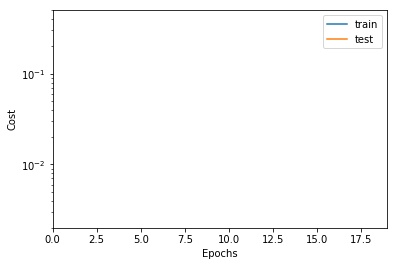

In [16]:
plt.semilogy(learning_curves["epochs"], learning_curves["cost_train"], label="train")
plt.semilogy(learning_curves["epochs"], learning_curves["cost_test"], label="test")
plt.ylabel('Cost')
plt.xlabel('Epochs')
xmax = learning_curves["epochs"][-1]
plt.axis([0,xmax,0.002,0.5])
plt.legend()
plt.show()

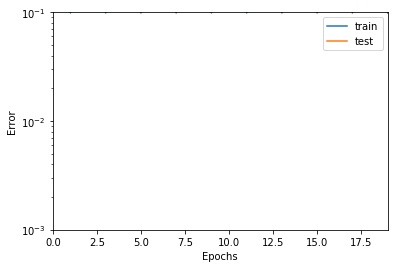

In [17]:
plt.semilogy(learning_curves["epochs"], learning_curves["error_train"], label="train")
plt.semilogy(learning_curves["epochs"], learning_curves["error_test"], label="test")
plt.ylabel('Error')
plt.xlabel('Epochs')
xmax = learning_curves["epochs"][-1]
plt.axis([0,xmax,0.001,0.1])
plt.legend()
plt.show()

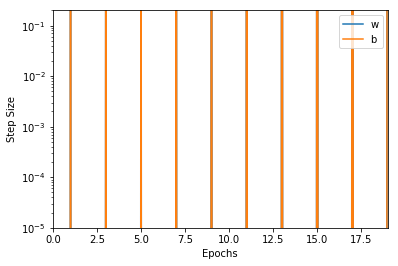

In [18]:
plt.semilogy(learning_curves["epochs"], learning_curves["step_w"], label="w")
plt.semilogy(learning_curves["epochs"], learning_curves["step_b"], label="b")
plt.ylabel('Step Size')
plt.xlabel('Epochs')
xmax = learning_curves["epochs"][-1]
plt.axis([0,xmax,0.00001,0.2])
plt.legend()
plt.show()

40
[  9  18  25  56  72  84  87  98 100 101 103 119 121 129 133 136 138 146
 148 152 163 181 191 200 210 247 248 250 256 257 263 283 286 293 314 326
 333 340 344 355]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[-4.04958177e+44 -4.78064450e+44 -5.32099521e+44 -5.98848727e+44
  -4.41511313e+44 -5.08260519e+44 -4.46279114e+44 -5.70241924e+44
  -5.17796120e+44 -4.86010784e+44 -5.25742454e+44 -4.71707383e+44
  -4.19261578e+44 -4.70118116e+44 -5.03492719e+44 -4.87600051e+44
  -4.84421517e+44 -4.92367851e+44 -4.58993248e+44 -5.03492719e+44
  -4.68528849e+44 -5.44813656e+44 -4.55814715e+44 -4.27207912e+44
  -5.16206853e+44 -5.20974653e+44 -5.63884857e+44 -4.78064450

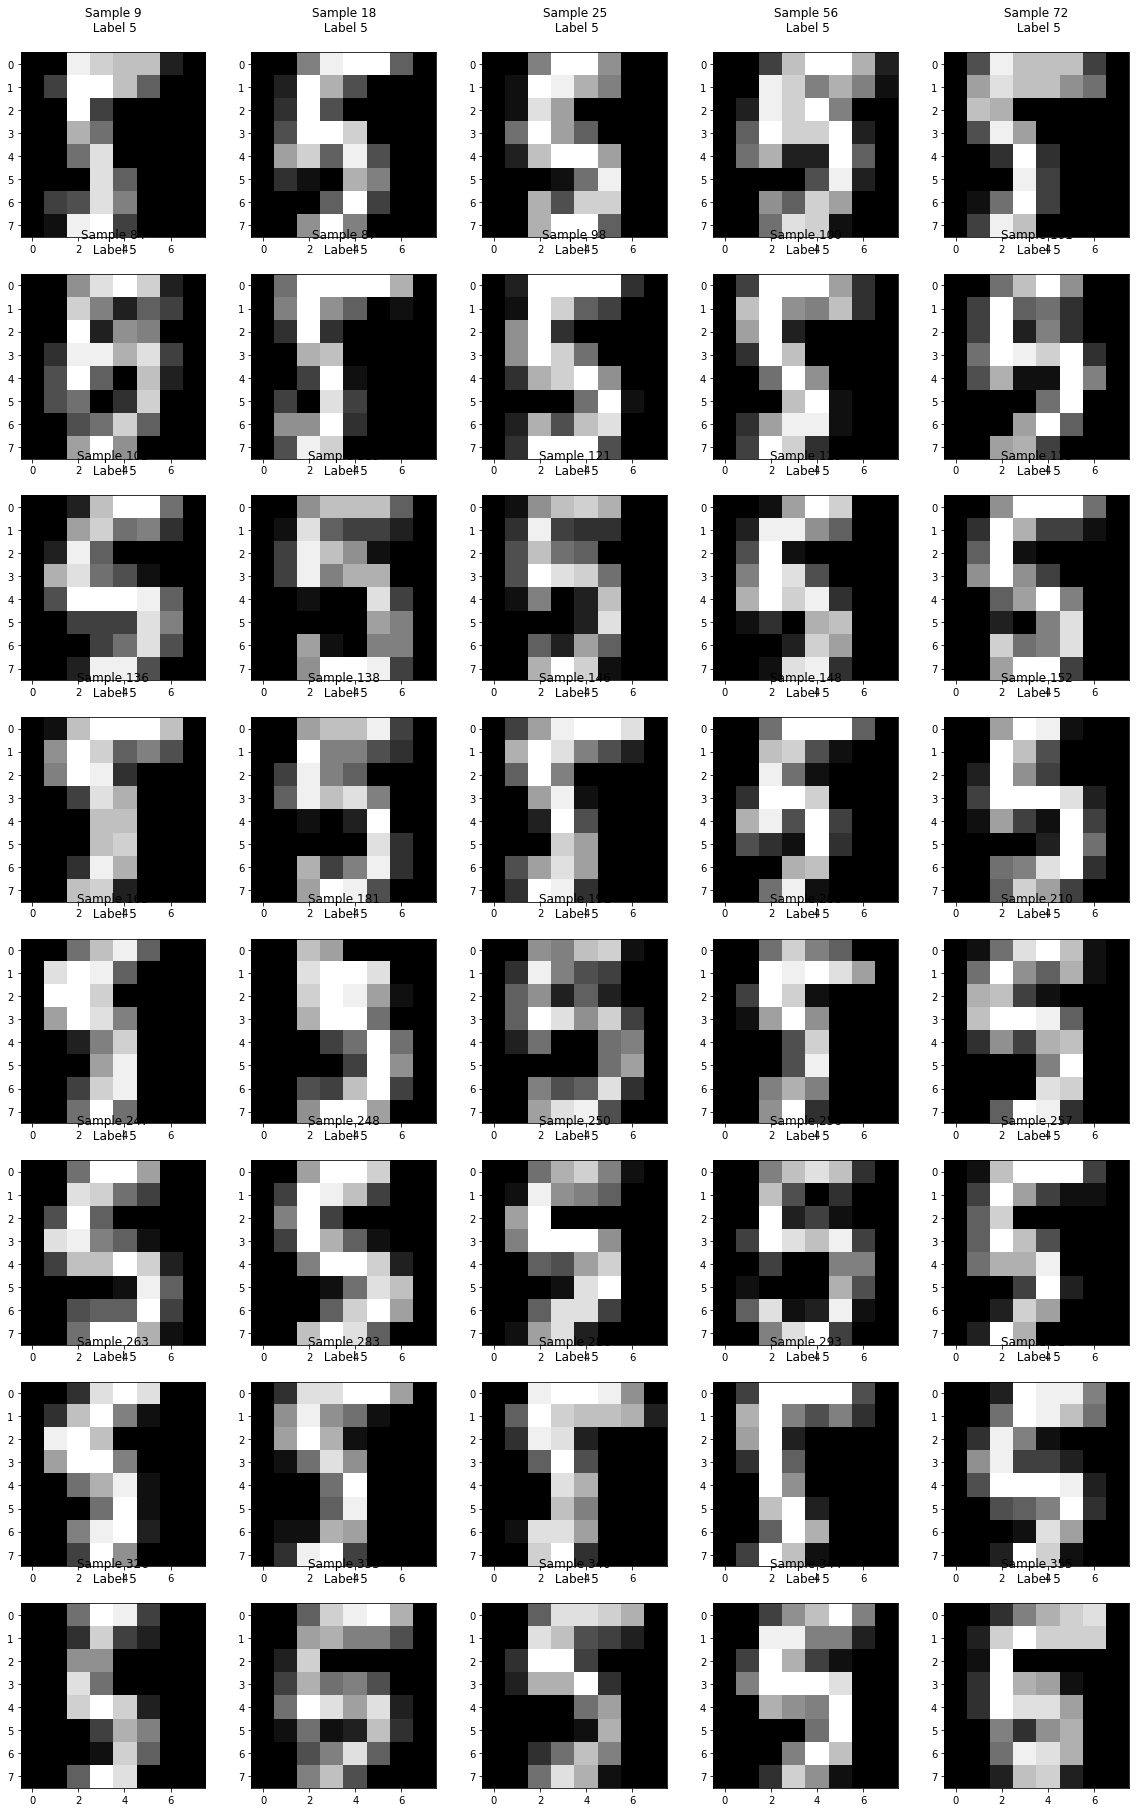

In [19]:
Y_pred = predict(params['w'], params['b'], X_test, round=True)
indices = np.where(Y_test!=Y_pred)[1]
print(len(indices))
print(indices)
print(Y_test[:,indices])
print(Y_pred[:,indices])
print(predict(params['w'], params['b'], X_test[:,indices]))

plot_digits(x_test, y_test, indices)

### Plot the Trained Weights as 8x8 Image 

[[-25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000]
 [-25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000]
 [-25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -25428268803184852456103628786189528230526976.000
  -2542826

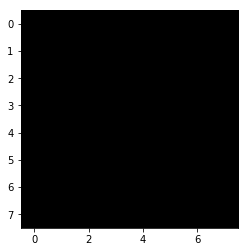

In [20]:
plt.imshow(np.reshape(params['w'], (8,8)), cmap=plt.cm.gray)
np.set_printoptions(precision=3, formatter={'float': '{: 0.3f}'.format})

print(np.reshape(params['w'], (8,8)))
print(params['b'])

### Analysis for all the Digits

Run batch gradient descent independently for all the digits (0-9).<br>
Plot the error rates (train and test) for the trained models against the digit in a single plot. <br>
Which digit can be predicted very well - for which is the prediction rather bad? <br>
Plot the digits and interpret what you see.

In [21]:
### START YOUR CODE ###



### END YOUR CODE ###